In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB). PLEASE USE APPROPRIATE PATH TO TASK1

In [3]:
#set title for saving model correctly!!!
title = "mel_vs_nev&seb_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#initializing the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 18s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [10]:
#Adding additional layers to the ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)               #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                 #Configuring learning rate
    drop = 0.1                                                              
    epochs_drop = 10.0                                                     #Configuring epoch drop
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:
#Function for plotting the train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  #  ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)           #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')      #Calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged_augumented/task1"
test_dir = "/content/drive/MyDrive/msc_project/test/task1"

In [16]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [17]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [18]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.5529
Epoch 1: val_accuracy improved from -inf to 0.51923, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_1.hdf5
104/104 [==============================] - 970s 9s/step - loss: 0.8208 - accuracy: 0.5529 - val_loss: 0.7587 - val_accuracy: 0.5192 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.5808
Epoch 2: val_accuracy improved from 0.51923 to 0.78077, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_1.hdf5
104/104 [==============================] - 816s 8s/step - loss: 0.7430 - accuracy: 0.5808 -

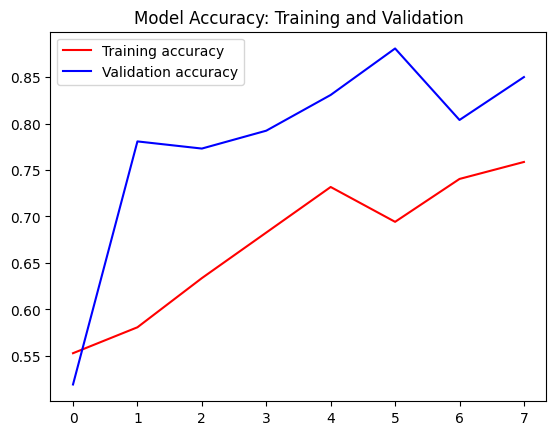

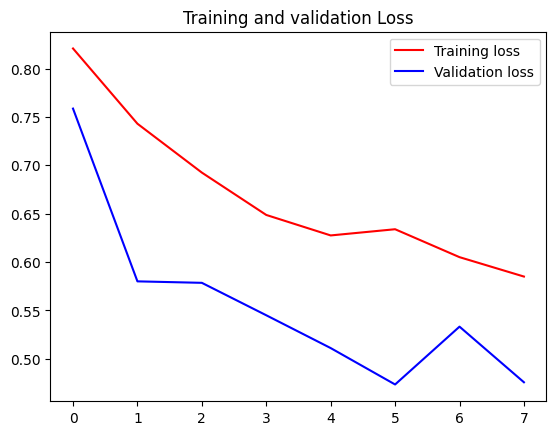

<Figure size 640x480 with 0 Axes>

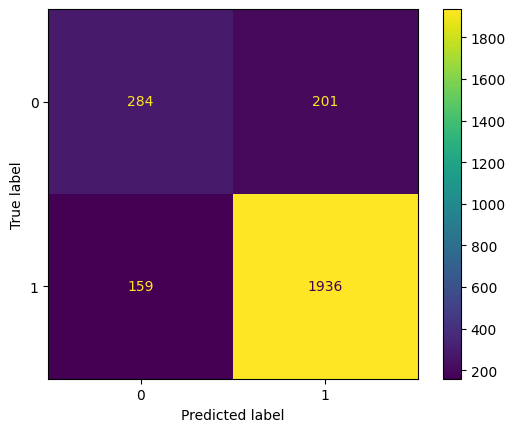


               precision    recall  f1-score   support

           0       0.64      0.59      0.61       485
           1       0.91      0.92      0.91      2095

    accuracy                           0.86      2580
   macro avg       0.77      0.75      0.76      2580
weighted avg       0.86      0.86      0.86      2580

Sensitivity: 0.924 Specificity: 0.586 Precision: 0.856 ROC_AUC_SCORE: 0.845



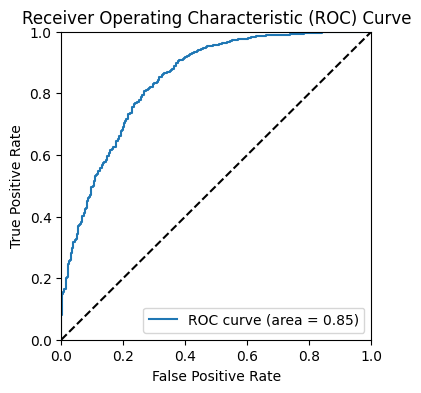

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.66154, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_2.hdf5
104/104 [==============================] - 377s 3s/step - loss: 0.6157 - accuracy: 0.7365 - val_loss: 0.7202 - val_accuracy: 0.6615 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7510
Epoch 2: val_accuracy improved from 0.66154 to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_2.hdf5
104/104 [==============================] - 285s 3s/step - loss: 0.59

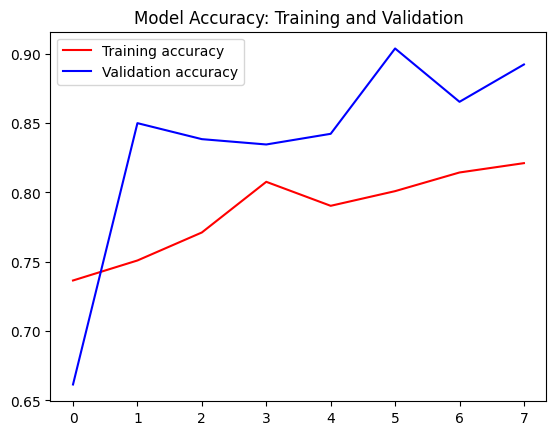

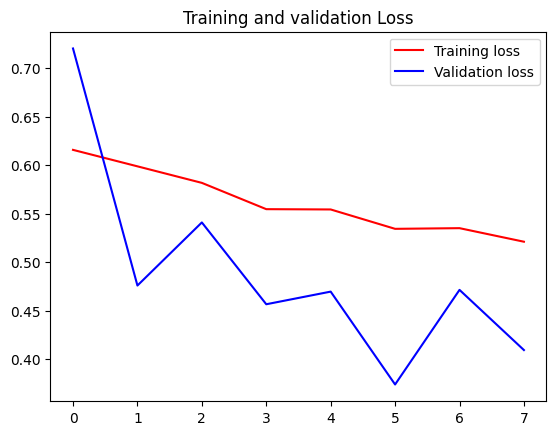

<Figure size 640x480 with 0 Axes>

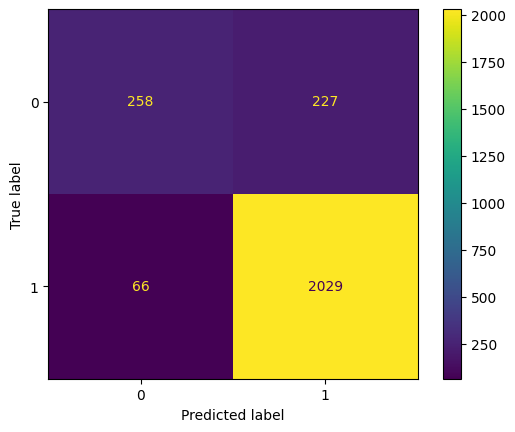


               precision    recall  f1-score   support

           0       0.80      0.53      0.64       485
           1       0.90      0.97      0.93      2095

    accuracy                           0.89      2580
   macro avg       0.85      0.75      0.79      2580
weighted avg       0.88      0.89      0.88      2580

Sensitivity: 0.968 Specificity: 0.532 Precision: 0.88 ROC_AUC_SCORE: 0.866



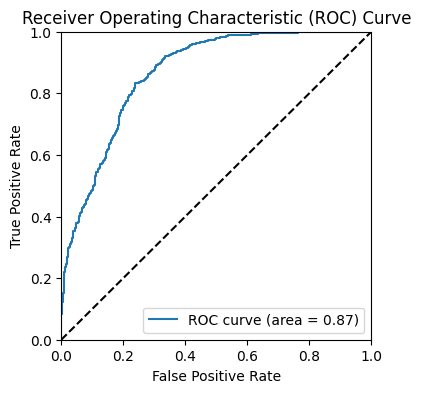

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.89231, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_3.hdf5
104/104 [==============================] - 170s 1s/step - loss: 0.5411 - accuracy: 0.8125 - val_loss: 0.4151 - val_accuracy: 0.8923 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.8115
Epoch 2: val_accuracy did not improve from 0.89231
104/104 [==============================] - 95s 921ms/step - loss: 0.5370 - accuracy: 0.8115 - val_loss: 0.5663 - val_accuracy: 0.8000 - lr: 2.0000e-05

Epoch 3: Learni

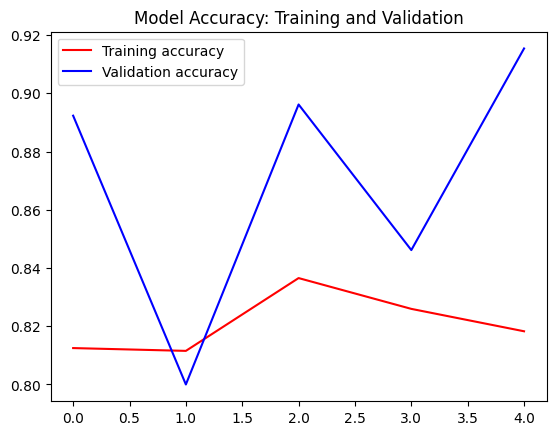

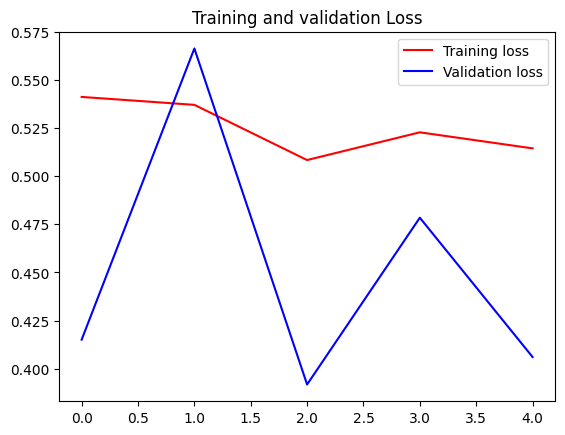

<Figure size 640x480 with 0 Axes>

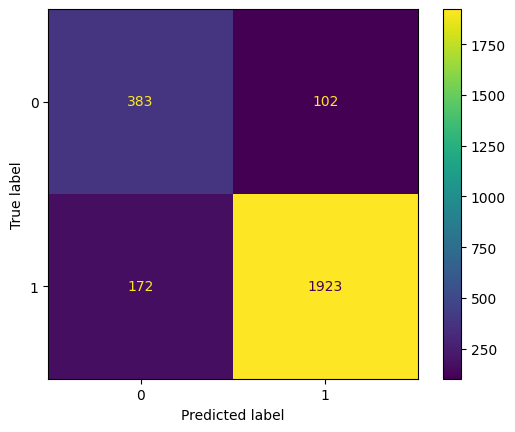


               precision    recall  f1-score   support

           0       0.69      0.79      0.74       485
           1       0.95      0.92      0.93      2095

    accuracy                           0.89      2580
   macro avg       0.82      0.85      0.84      2580
weighted avg       0.90      0.89      0.90      2580

Sensitivity: 0.918 Specificity: 0.79 Precision: 0.901 ROC_AUC_SCORE: 0.936



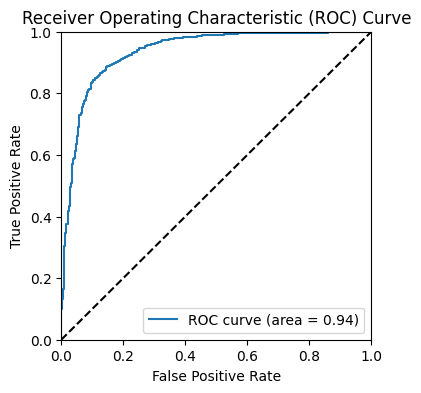

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.8519
Epoch 1: val_accuracy improved from -inf to 0.88462, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_4.hdf5
104/104 [==============================] - 131s 789ms/step - loss: 0.4940 - accuracy: 0.8519 - val_loss: 0.4435 - val_accuracy: 0.8846 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.8740
Epoch 2: val_accuracy did not improve from 0.88462
104/104 [==============================] - 68s 659ms/step - loss: 0.4614 - accuracy: 0.8740 - val_loss: 0.4240 - val_accuracy: 0.8654 - lr: 2.0000e-05

Epoch 3: Lea

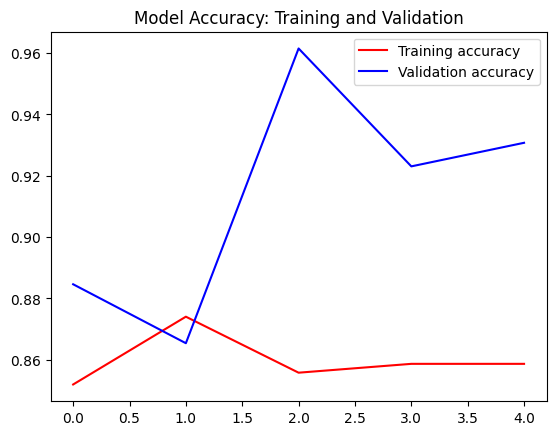

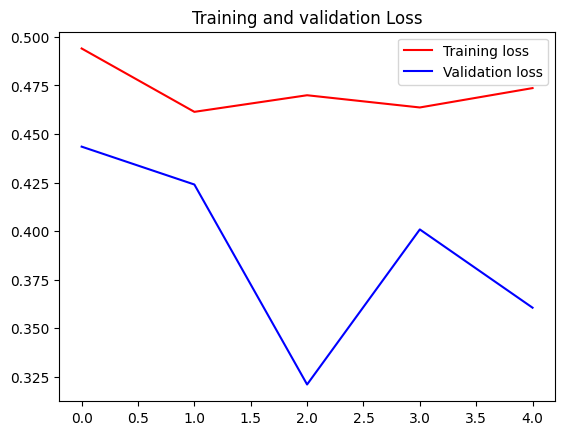

<Figure size 640x480 with 0 Axes>

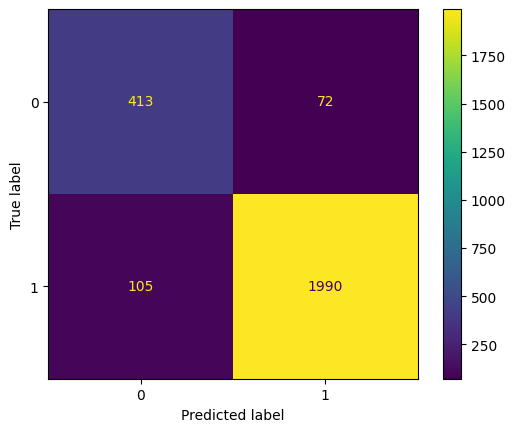


               precision    recall  f1-score   support

           0       0.80      0.85      0.82       485
           1       0.97      0.95      0.96      2095

    accuracy                           0.93      2580
   macro avg       0.88      0.90      0.89      2580
weighted avg       0.93      0.93      0.93      2580

Sensitivity: 0.95 Specificity: 0.852 Precision: 0.934 ROC_AUC_SCORE: 0.958



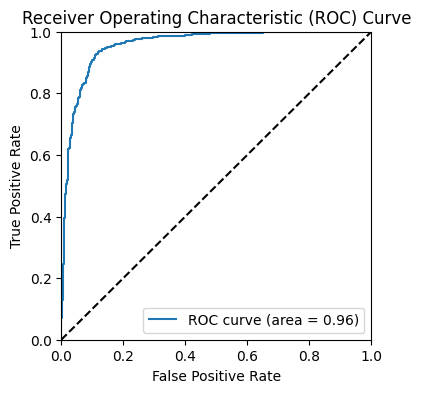

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.8529
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_aug/model_fold_5.hdf5
104/104 [==============================] - 120s 693ms/step - loss: 0.4743 - accuracy: 0.8529 - val_loss: 0.3649 - val_accuracy: 0.9500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8596
Epoch 2: val_accuracy did not improve from 0.95000
104/104 [==============================] - 57s 551ms/step - loss: 0.4607 - accuracy: 0.8596 - val_loss: 0.4479 - val_accuracy: 0.9038 - lr: 2.0000e-05

Epoch 3: Lea

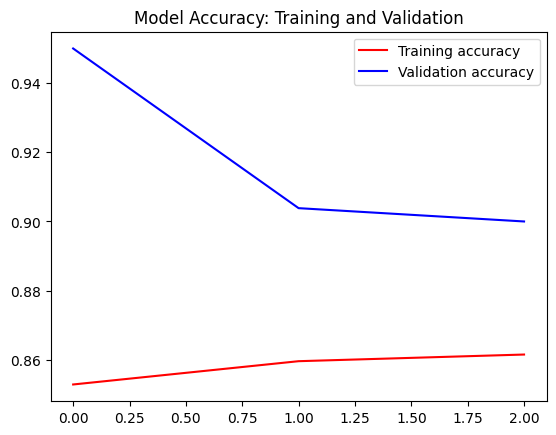

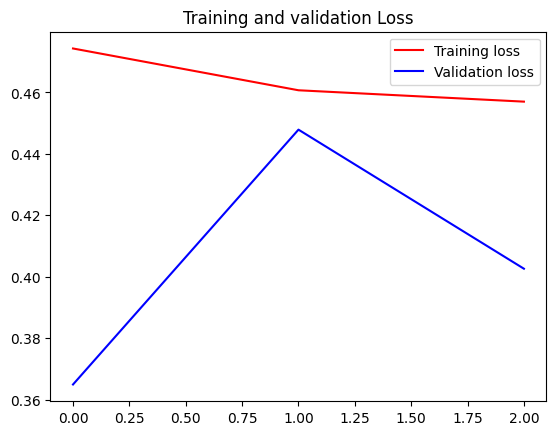

<Figure size 640x480 with 0 Axes>

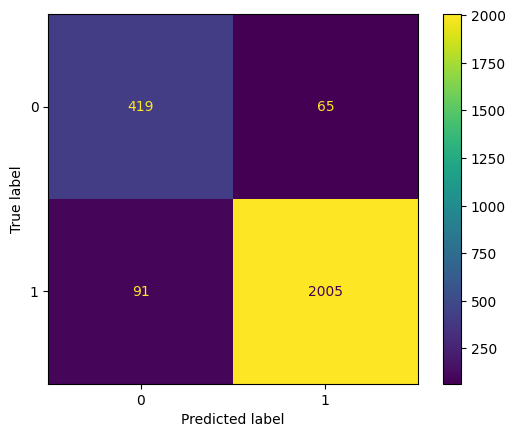


               precision    recall  f1-score   support

           0       0.82      0.87      0.84       484
           1       0.97      0.96      0.96      2096

    accuracy                           0.94      2580
   macro avg       0.90      0.91      0.90      2580
weighted avg       0.94      0.94      0.94      2580

Sensitivity: 0.957 Specificity: 0.866 Precision: 0.941 ROC_AUC_SCORE: 0.969



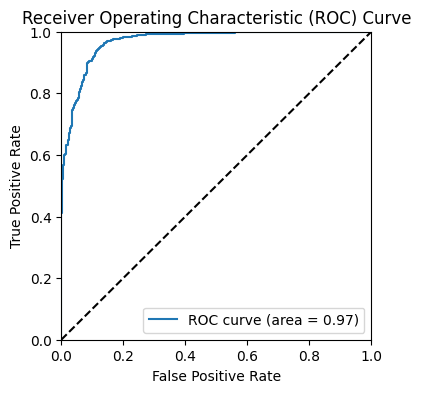

Validation complete...


In [19]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [20]:
test_dir

'/content/drive/MyDrive/msc_project/test/task1'

In [21]:
#Test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 273s 455ms/step


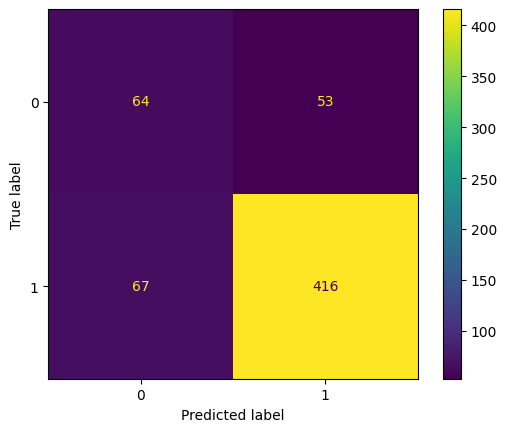


               precision    recall  f1-score   support

           0       0.49      0.55      0.52       117
           1       0.89      0.86      0.87       483

    accuracy                           0.80       600
   macro avg       0.69      0.70      0.70       600
weighted avg       0.81      0.80      0.80       600

Sensitivity: 0.861 Specificity: 0.547 Precision: 0.809 ROC_AUC_SCORE: 0.748



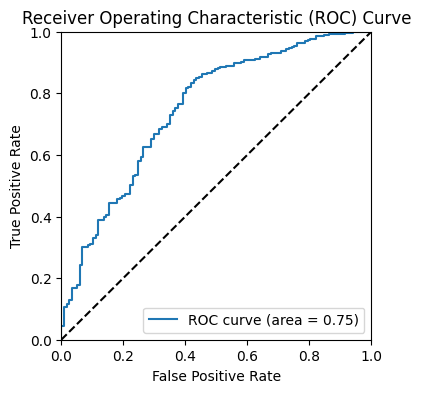

Testing Complete
Test using model 2
600/600 [==============================] - 24s 40ms/step


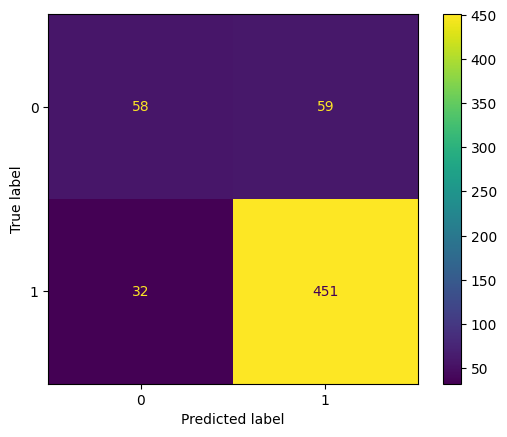


               precision    recall  f1-score   support

           0       0.64      0.50      0.56       117
           1       0.88      0.93      0.91       483

    accuracy                           0.85       600
   macro avg       0.76      0.71      0.73       600
weighted avg       0.84      0.85      0.84       600

Sensitivity: 0.934 Specificity: 0.496 Precision: 0.838 ROC_AUC_SCORE: 0.811



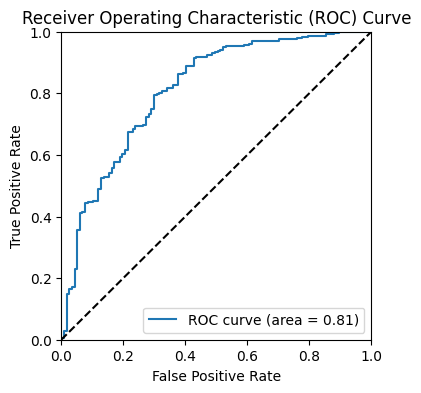

Testing Complete
Test using model 3
600/600 [==============================] - 26s 43ms/step


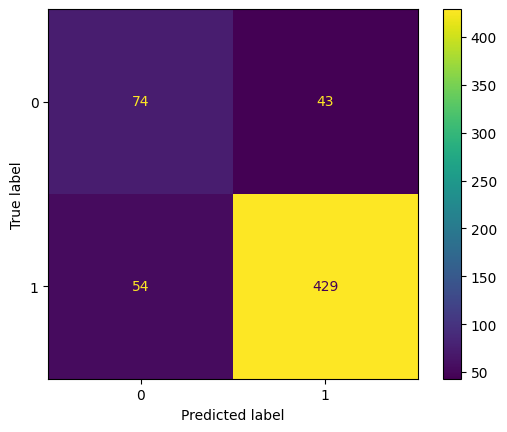


               precision    recall  f1-score   support

           0       0.58      0.63      0.60       117
           1       0.91      0.89      0.90       483

    accuracy                           0.84       600
   macro avg       0.74      0.76      0.75       600
weighted avg       0.84      0.84      0.84       600

Sensitivity: 0.888 Specificity: 0.632 Precision: 0.844 ROC_AUC_SCORE: 0.829



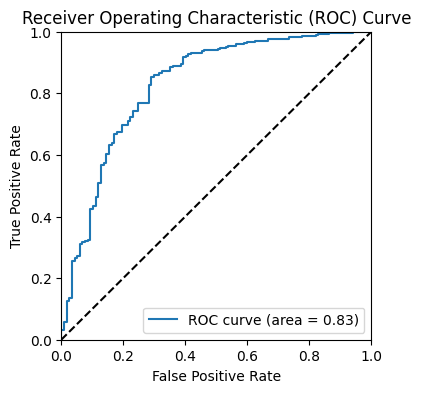

Testing Complete
Test using model 4
600/600 [==============================] - 26s 43ms/step


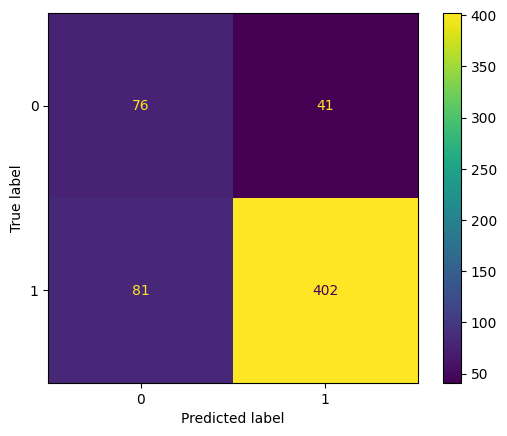


               precision    recall  f1-score   support

           0       0.48      0.65      0.55       117
           1       0.91      0.83      0.87       483

    accuracy                           0.80       600
   macro avg       0.70      0.74      0.71       600
weighted avg       0.82      0.80      0.81       600

Sensitivity: 0.832 Specificity: 0.65 Precision: 0.825 ROC_AUC_SCORE: 0.801



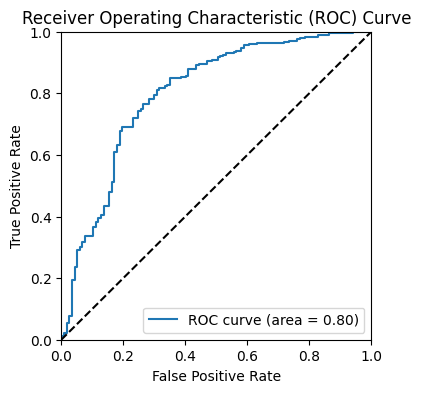

Testing Complete
Test using model 5
600/600 [==============================] - 31s 52ms/step


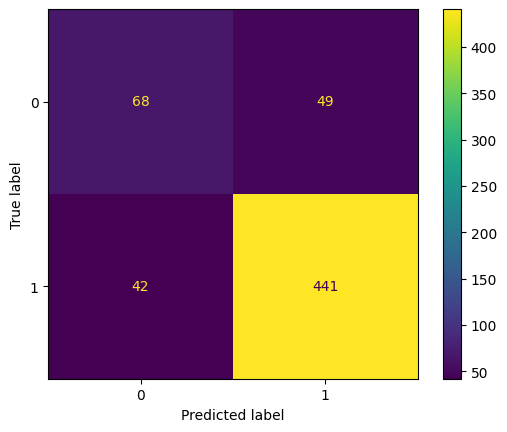


               precision    recall  f1-score   support

           0       0.62      0.58      0.60       117
           1       0.90      0.91      0.91       483

    accuracy                           0.85       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.85      0.85      0.85       600

Sensitivity: 0.913 Specificity: 0.581 Precision: 0.845 ROC_AUC_SCORE: 0.813



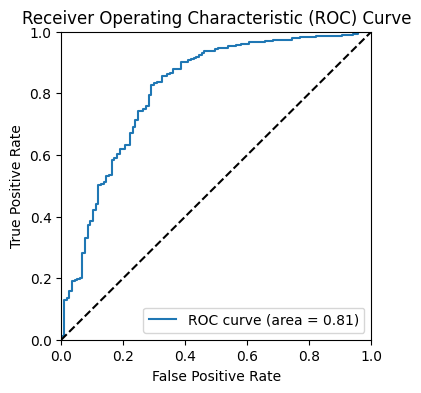

Testing Complete


In [22]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")